In [1]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt
import matplotlib as mpl
from cycler import cycler
import numpy as np
import scipy.stats as sps
from scipy.constants import golden_ratio

import json, pickle, os, corner, glob, sys
from collections import defaultdict, OrderedDict
from copy import deepcopy
import pandas as pd
from astropy.time import Time
import astropy.units as u

from PTMCMCSampler.PTMCMCSampler import PTSampler as ptmcmc

Do not have mpi4py package.


In [3]:
color_cycle_wong = ['#000000','#E69F00','#009E73','#56B4E9','#0072B2','#F0E442','#D55E00','#CC79A7']
Six_color_cycle = ["#5790FC", "#F89C20", "#E42536", "#964A8B", "#9C9CA1", "#7A21DD"]
Eight_color_cycle = ["#1845FB", "#FF5E02", "#C91F16", "#C849A9", "#ADAD7D", "#86C8DD", "#578DFF", "#656364"]
Ten_color_cycle = ["#3F90DA", "#FFA90E", "#BD1F01", "#94A4A2", "#832DB6", "#A96B59", "#E76300", "#B9AC70", "#717581", "#92DADD"]
mpl.rcParams['axes.prop_cycle'] = cycler(color=Eight_color_cycle)
def get_fig_size(width=15,scale=1.):
    #width = 3.36 # 242 pt
    base_size = np.array([1, 1/scale/golden_ratio])
    fig_size = width * base_size
    return(fig_size)
mpl.rcParams['figure.figsize'] = get_fig_size()
mpl.rcParams['text.usetex'] = False
mpl.rc('font',**{'family':'serif','serif':['Times New Roman']})
mpl.rcParams['lines.linewidth'] = 3
mpl.rcParams['lines.markersize'] = 10
mpl.rcParams['axes.labelsize'] = 30
mpl.rcParams['xtick.labelsize'] = 20
mpl.rcParams['ytick.labelsize'] = 20
mpl.rcParams['legend.fontsize'] = 20
mpl.rcParams['axes.titlesize'] = 20
#mpl.rcParams["figure.dpi"] = 300

In [4]:
current_path = os.getcwd()
splt_path = current_path.split("/")
#top_path_idx = splt_path.index("akaiser")
top_path_idx = splt_path.index("nanograv")
top_dir = "/".join(splt_path[0 : top_path_idx + 1])

In [5]:
la_f_path = top_dir + "/la_forge"
e_e_path = top_dir + "/enterprise_extensions/"
sys.path.insert(0, la_f_path)
sys.path.insert(0, e_e_path)
sys.path.insert(0, top_dir + "/enterprise_timing")

In [6]:
import enterprise
from enterprise.pulsar import Pulsar
from enterprise.signals import utils
from enterprise.signals import parameter
from enterprise.signals import white_signals
from enterprise.signals import signal_base
from enterprise.signals import selections

import enterprise_extensions as e_e
from enterprise_extensions import sampler
from enterprise_extensions import models
from enterprise_extensions.sampler import JumpProposal
from enterprise_extensions.timing import timing_block
from enterprise_extensions.blocks import channelized_backends

In [8]:
import la_forge
import la_forge.diagnostics as dg
from la_forge.core import TimingCore
from la_forge.core import Core

import nltm_plot_utils_v4 as nltm_plt
from nltm_setup_universal_pta_v1 import pta_setup

In [9]:
psr_name = 'J2043+1711'#'J0740+6620'#'J0340+4130'#'J1640+2224'#'J2043+1711'#'J2317+1439' 'J1909-3744'
dataset='9yr'
parfile = top_dir + f"/9yr/par/{psr_name}_NANOGrav_9yv1.gls.par"
timfile = top_dir + f"/9yr/tim/{psr_name}_NANOGrav_9yv1.tim"
outdir = top_dir + f"/enterprise_timing/{psr_name}/chains/{dataset}/{psr_name}_uniform_DE421_nltm_ltm_testing_123/"

ephem = 'DE421'

In [10]:
psr = Pulsar(parfile, timfile, ephem=ephem, clk=None, drop_t2pulsar=False)

In [11]:
pta = pta_setup(psr,"9yr",psr_name,
                tm_var=True,red_var=False,
                white_var=True,fit_remaining_pars=True,
                lin_dmx_jump_fd=True,
                tm_linear=False,
                incTimingModel=True,
                Ecorr_gp_basis=False,
                pal2_priors=True)

Non-linearly varying these values:  ['PMELONG', 'PMELAT', 'PX', 'COSI', 'PB', 'A1', 'TASC', 'EPS1', 'EPS2', 'M2'] 
 in pulsar  J2043+1711
Linearly varying these values:  ['Offset', 'ELONG', 'ELAT', 'F0', 'F1', 'FD1', 'DMX_0001', 'DMX_0002', 'DMX_0003', 'DMX_0004', 'DMX_0005', 'DMX_0006', 'DMX_0007', 'DMX_0008', 'DMX_0009', 'DMX_0010', 'DMX_0011', 'DMX_0012', 'DMX_0013', 'DMX_0014', 'DMX_0015', 'DMX_0016', 'DMX_0017', 'DMX_0018', 'DMX_0019', 'DMX_0020', 'DMX_0021', 'DMX_0022', 'DMX_0023', 'JUMP1']
Using  uniform  prior.
COSI added to tm_params_orig for to work with tm_delay.


In [20]:
mysampler = sampler.setup_sampler(pta, resume = False, outdir = outdir)


Adding timing model jump proposal...

Adding timing model prior draw...



In [22]:
mysampler.groups.append([1,4,7,6])

In [23]:
mysampler.groups

[[0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21],
 [19, 18, 20, 13, 17, 12, 21, 14, 15, 16],
 [0, 3, 6, 9],
 [2, 5, 8, 11],
 [1, 4, 7, 10],
 [1, 4, 7, 6]]

In [12]:
# dimension of parameter space
params = pta.param_names
ndim = len(params)

# initial jump covariance matrix
cov = np.diag(np.ones(ndim) * 0.1 ** 2)

# parameter groupings
groups = sampler.get_parameter_groups(pta)
groups.extend(sampler.get_timing_groups(pta))

psampler = ptmcmc(
    ndim,
    pta.get_lnlikelihood,
    pta.get_lnprior,
    cov,
    groups=groups,
    outDir=outdir,
    resume=False,
)

# additional jump proposals
jp = JumpProposal(pta, empirical_distr=None, timing=True)
psampler.jp = jp

# always add draw from prior
psampler.addProposalToCycle(jp.draw_from_prior, 1)

# Red noise prior draw
if "red noise" in jp.snames:
    print("Adding red noise prior draws...\n")
    psampler.addProposalToCycle(jp.draw_from_red_prior, 1)

# Non Linear Timing Draws
if "timing_model" in jp.snames:
    print("Adding timing model jump proposal...\n")
    psampler.addProposalToCycle(jp.draw_from_timing_model, 1)
if "timing_model" in jp.snames:
    print("Adding timing model prior draw...\n")
    psampler.addProposalToCycle(jp.draw_from_timing_model_prior, 1)
    
# White Noise Draws
if "timing_model" in jp.snames and any("ecorr" in x for x in jp.snames.keys()):
    print("Adding ECORR + timing model jump proposal...\n")
    #psampler.addProposalToCycle(jp.draw_from_ecorr_and_timing_model, 1)

Adding timing model jump proposal...

Adding timing model prior draw...

Adding ECORR + timing model jump proposal...



In [13]:
[x for x in jp.snames.keys()]

['ecorr_sherman-morrison',
 'efac',
 'equad',
 'linear timing model',
 'timing_model']

In [14]:
pta.param_names

['J2043+1711_430_ASP_efac',
 'J2043+1711_430_ASP_log10_ecorr',
 'J2043+1711_430_ASP_log10_equad',
 'J2043+1711_430_PUPPI_efac',
 'J2043+1711_430_PUPPI_log10_ecorr',
 'J2043+1711_430_PUPPI_log10_equad',
 'J2043+1711_L-wide_ASP_efac',
 'J2043+1711_L-wide_ASP_log10_ecorr',
 'J2043+1711_L-wide_ASP_log10_equad',
 'J2043+1711_L-wide_PUPPI_efac',
 'J2043+1711_L-wide_PUPPI_log10_ecorr',
 'J2043+1711_L-wide_PUPPI_log10_equad',
 'J2043+1711_timing_model_A1',
 'J2043+1711_timing_model_COSI',
 'J2043+1711_timing_model_EPS1',
 'J2043+1711_timing_model_EPS2',
 'J2043+1711_timing_model_M2',
 'J2043+1711_timing_model_PB',
 'J2043+1711_timing_model_PMELAT',
 'J2043+1711_timing_model_PMELONG',
 'J2043+1711_timing_model_PX',
 'J2043+1711_timing_model_TASC']

In [15]:
sampler.get_timing_groups(pta)

[[20], [17, 12, 14, 15, 13, 16, 21], [19, 18]]

In [16]:
[x for x in pta.param_names if any(y in x for y in ["timing_model","ecorr"])]

['J2043+1711_430_ASP_log10_ecorr',
 'J2043+1711_430_PUPPI_log10_ecorr',
 'J2043+1711_L-wide_ASP_log10_ecorr',
 'J2043+1711_L-wide_PUPPI_log10_ecorr',
 'J2043+1711_timing_model_A1',
 'J2043+1711_timing_model_COSI',
 'J2043+1711_timing_model_EPS1',
 'J2043+1711_timing_model_EPS2',
 'J2043+1711_timing_model_M2',
 'J2043+1711_timing_model_PB',
 'J2043+1711_timing_model_PMELAT',
 'J2043+1711_timing_model_PMELONG',
 'J2043+1711_timing_model_PX',
 'J2043+1711_timing_model_TASC']

In [17]:
any("ecorr" in x for x in pta.param_names)

True

In [18]:
sampler.group_from_params(pta, [x for x in pta.param_names if any(y in x for y in ["timing_model","ecorr"])])

[1, 4, 7, 10, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21]

In [19]:
# parameter groupings
groups = sampler.get_parameter_groups(pta)
groups.extend(sampler.get_timing_groups(pta))
groups.append(sampler.group_from_params(pta,
                                        [x for x in pta.param_names if any(y in x for y in ["timing_model","ecorr"])]))
for grp in groups:
    if not isinstance(grp,(int,np.int64)):
        for subgrp in grp:
            print(psampler.jp.pnames[subgrp])
    else:
        print(psampler.jp.pnames[grp])
    print('------------')

J2043+1711_430_ASP_efac
J2043+1711_430_ASP_log10_ecorr
J2043+1711_430_ASP_log10_equad
J2043+1711_430_PUPPI_efac
J2043+1711_430_PUPPI_log10_ecorr
J2043+1711_430_PUPPI_log10_equad
J2043+1711_L-wide_ASP_efac
J2043+1711_L-wide_ASP_log10_ecorr
J2043+1711_L-wide_ASP_log10_equad
J2043+1711_L-wide_PUPPI_efac
J2043+1711_L-wide_PUPPI_log10_ecorr
J2043+1711_L-wide_PUPPI_log10_equad
J2043+1711_timing_model_A1
J2043+1711_timing_model_COSI
J2043+1711_timing_model_EPS1
J2043+1711_timing_model_EPS2
J2043+1711_timing_model_M2
J2043+1711_timing_model_PB
J2043+1711_timing_model_PMELAT
J2043+1711_timing_model_PMELONG
J2043+1711_timing_model_PX
J2043+1711_timing_model_TASC
------------
J2043+1711_timing_model_PMELONG
J2043+1711_timing_model_PMELAT
J2043+1711_timing_model_PX
J2043+1711_timing_model_COSI
J2043+1711_timing_model_PB
J2043+1711_timing_model_A1
J2043+1711_timing_model_TASC
J2043+1711_timing_model_EPS1
J2043+1711_timing_model_EPS2
J2043+1711_timing_model_M2
------------
J2043+1711_430_ASP_efac
J2

In [19]:
# pickled_pta = cloudpickle.dumps(pta)
print(psampler.jp.tm_groups)
for grp in psampler.jp.tm_groups:
    if not isinstance(grp,np.int64):
        for subgrp in grp:
            print(psampler.jp.pnames[subgrp])
    else:
        print(psampler.jp.pnames[grp])
    print('------------')
print(psampler.jp.special_idxs)
print(len(psampler.propCycle))

[list([20]) list([17, 12, 14, 15, 13, 16, 21]) list([19, 18]) 12 13 14 15
 16 17 18 19 20 21]
J2043+1711_timing_model_PX
------------
J2043+1711_timing_model_PB
J2043+1711_timing_model_A1
J2043+1711_timing_model_EPS1
J2043+1711_timing_model_EPS2
J2043+1711_timing_model_COSI
J2043+1711_timing_model_M2
J2043+1711_timing_model_TASC
------------
J2043+1711_timing_model_PMELONG
J2043+1711_timing_model_PMELAT
------------
J2043+1711_timing_model_A1
------------
J2043+1711_timing_model_COSI
------------
J2043+1711_timing_model_EPS1
------------
J2043+1711_timing_model_EPS2
------------
J2043+1711_timing_model_M2
------------
J2043+1711_timing_model_PB
------------
J2043+1711_timing_model_PMELAT
------------
J2043+1711_timing_model_PMELONG
------------
J2043+1711_timing_model_PX
------------
J2043+1711_timing_model_TASC
------------
[13, 16, 20]
3


In [20]:
zero_start=True
if zero_start:
    x0_list = []
    for p in pta.params:
        if "timing" in p.name:
            if "DMX" in p.name:
                p_name = ("_").join(p.name.split("_")[-2:])
            else:
                p_name = p.name.split("_")[-1]
            if psr.tm_params_orig[p_name][-1] == "normalized":
                x0_list.append(np.double(0.0))
            else:
                x0_list.append(np.double(psr.tm_params_orig[p_name][0]))
        else:
            x0_list.append(p.sample())
    x0 = np.asarray(x0_list)
else:
    x0 = np.hstack([p.sample() for p in pta.params])
x0

array([ 9.79926354, -5.13889267, -7.85968651,  7.83624754, -4.52192356,
       -8.20726502,  0.7070427 , -7.03593017, -4.57492537,  3.12782824,
       -7.72661813, -9.40979041,  0.        ,  0.11607886,  0.        ,
        0.        ,  0.172879  ,  0.        ,  0.        ,  0.        ,
        0.7777    ,  0.        ])

In [21]:
pta.params[-2].sample()

21.894792368874498

In [22]:
for pcyc in psampler.propCycle:
    print(pcyc.__name__)
    q,qxy = pcyc(x0, 0, 1.)
    print(q)
    print('change')
    print(q-x0)
    print('---------------')
    print('---------------')
    print('')

draw_from_prior
[ 9.79926354 -5.13889267 -7.85968651  7.83624754 -4.52192356 -8.20726502
  0.7070427  -7.03593017 -4.57492537  3.12782824 -7.72661813 -4.18720518
  0.          0.11607886  0.          0.          0.172879    0.
  0.          0.          0.7777      0.        ]
change
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         5.22258523
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.        ]
---------------
---------------

draw_from_timing_model
[ 9.79926354 -5.13889267 -7.85968651  7.83624754 -4.52192356 -8.20726502
  0.7070427  -7.03593017 -4.57492537  3.12782824 -7.72661813 -9.40979041
  0.          0.11607886  0.          0.          0.172879    0.
 -1.66948882 -0.3345864   0.7777      0.        ]
change
[ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.   

In [23]:
num_iters = int(1e5)
tm_draws = defaultdict(list)
tm_prior_draws = defaultdict(list)
for iters in range(num_iters):
    for pcyc in psampler.propCycle:
        if pcyc.__name__ == 'draw_from_timing_model':
            q,qxy = pcyc(x0, 0, 1.)
            for i,draw in enumerate((q-x0)):
                if draw != 0.:
                    tm_draws[pta.param_names[i]].append(q[i])
        elif pcyc.__name__ == 'draw_from_timing_model_prior':
            q,qxy = pcyc(x0, 0, 1.)
            for i,draw in enumerate((q-x0)):
                if draw != 0.:
                    tm_prior_draws[pta.param_names[i]].append(q[i])

In [24]:
pta.params

[J2043+1711_430_ASP_efac:Uniform(pmin=0.001, pmax=10.0),
 J2043+1711_430_ASP_log10_ecorr:Uniform(pmin=-8.5, pmax=-4.0),
 J2043+1711_430_ASP_log10_equad:Uniform(pmin=-10.0, pmax=-4.0),
 J2043+1711_430_PUPPI_efac:Uniform(pmin=0.001, pmax=10.0),
 J2043+1711_430_PUPPI_log10_ecorr:Uniform(pmin=-8.5, pmax=-4.0),
 J2043+1711_430_PUPPI_log10_equad:Uniform(pmin=-10.0, pmax=-4.0),
 J2043+1711_L-wide_ASP_efac:Uniform(pmin=0.001, pmax=10.0),
 J2043+1711_L-wide_ASP_log10_ecorr:Uniform(pmin=-8.5, pmax=-4.0),
 J2043+1711_L-wide_ASP_log10_equad:Uniform(pmin=-10.0, pmax=-4.0),
 J2043+1711_L-wide_PUPPI_efac:Uniform(pmin=0.001, pmax=10.0),
 J2043+1711_L-wide_PUPPI_log10_ecorr:Uniform(pmin=-8.5, pmax=-4.0),
 J2043+1711_L-wide_PUPPI_log10_equad:Uniform(pmin=-10.0, pmax=-4.0),
 J2043+1711_timing_model_A1:Uniform(pmin=-500.0, pmax=500.0),
 J2043+1711_timing_model_COSI:Uniform(pmin=0.0, pmax=1.0),
 J2043+1711_timing_model_EPS1:Uniform(pmin=-500.0, pmax=500.0),
 J2043+1711_timing_model_EPS2:Uniform(pmin=-500.0

In [26]:
print(str(pta.params[-1]))

J2043+1711_timing_model_TASC:Uniform(pmin=-500.0, pmax=500.0)


In [27]:
special_pars = []
for x in [str(y) for y in pta.params if "Uniform" in str(y) and "timing_model" in str(y)]:
    pmin = float(x.split('Uniform')[-1].split('pmin=')[1].split(',')[0])
    pmax = float(x.split('Uniform')[-1].split('pmax=')[-1].split(')')[0])
    if pmin+pmax != 0.0:
        special_pars.append(x.split(':')[0])
special_pars

['J2043+1711_timing_model_COSI',
 'J2043+1711_timing_model_M2',
 'J2043+1711_timing_model_PX']

In [28]:
#special_pars = ["PX", "SINI", "COSI", "ECC"]
[ii for par, ii in jp.pimap.items() if np.any([sp in par for sp in special_pars])]

[13, 16, 20]

In [39]:
pta.params

[J2043+1711_430_ASP_efac:Uniform(pmin=0.001, pmax=10.0),
 J2043+1711_430_ASP_log10_ecorr:Uniform(pmin=-8.5, pmax=-4.0),
 J2043+1711_430_ASP_log10_equad:Uniform(pmin=-10.0, pmax=-4.0),
 J2043+1711_430_PUPPI_efac:Uniform(pmin=0.001, pmax=10.0),
 J2043+1711_430_PUPPI_log10_ecorr:Uniform(pmin=-8.5, pmax=-4.0),
 J2043+1711_430_PUPPI_log10_equad:Uniform(pmin=-10.0, pmax=-4.0),
 J2043+1711_L-wide_ASP_efac:Uniform(pmin=0.001, pmax=10.0),
 J2043+1711_L-wide_ASP_log10_ecorr:Uniform(pmin=-8.5, pmax=-4.0),
 J2043+1711_L-wide_ASP_log10_equad:Uniform(pmin=-10.0, pmax=-4.0),
 J2043+1711_L-wide_PUPPI_efac:Uniform(pmin=0.001, pmax=10.0),
 J2043+1711_L-wide_PUPPI_log10_ecorr:Uniform(pmin=-8.5, pmax=-4.0),
 J2043+1711_L-wide_PUPPI_log10_equad:Uniform(pmin=-10.0, pmax=-4.0),
 J2043+1711_timing_model_A1:Uniform(pmin=-500.0, pmax=500.0),
 J2043+1711_timing_model_COSI:Uniform(pmin=0.0, pmax=1.0),
 J2043+1711_timing_model_EPS1:Uniform(pmin=-500.0, pmax=500.0),
 J2043+1711_timing_model_EPS2:Uniform(pmin=-500.0

In [44]:
special_pars = {}
for pta_par, (par, ii) in zip(pta.params,jp.pimap.items()):
    if "Uniform" in str(pta_par) and "timing_model" in par:
        pmin = float(pta_par.split('Uniform')[-1].split('pmin=')[1].split(',')[0])
        pmax = float(pta_par.split('Uniform')[-1].split('pmax=')[-1].split(')')[0])
        if pmin+pmax != 0.0:
            special_pars.append(x.split(':')[0])
            special_pars[x.split(':')[0]] = {}
        print(pta_par,par)

J2043+1711_timing_model_A1:Uniform(pmin=-500.0, pmax=500.0) J2043+1711_timing_model_A1
J2043+1711_timing_model_COSI:Uniform(pmin=0.0, pmax=1.0) J2043+1711_timing_model_COSI
J2043+1711_timing_model_EPS1:Uniform(pmin=-500.0, pmax=500.0) J2043+1711_timing_model_EPS1
J2043+1711_timing_model_EPS2:Uniform(pmin=-500.0, pmax=500.0) J2043+1711_timing_model_EPS2
J2043+1711_timing_model_M2:Uniform(pmin=1e-10, pmax=7.618379) J2043+1711_timing_model_M2
J2043+1711_timing_model_PB:Uniform(pmin=-500.0, pmax=500.0) J2043+1711_timing_model_PB
J2043+1711_timing_model_PMELAT:Uniform(pmin=-500.0, pmax=500.0) J2043+1711_timing_model_PMELAT
J2043+1711_timing_model_PMELONG:Uniform(pmin=-500.0, pmax=500.0) J2043+1711_timing_model_PMELONG
J2043+1711_timing_model_PX:Uniform(pmin=0.0, pmax=96.1777) J2043+1711_timing_model_PX
J2043+1711_timing_model_TASC:Uniform(pmin=-500.0, pmax=500.0) J2043+1711_timing_model_TASC


In [29]:
print(jp.pimap.items())

dict_items([('J2043+1711_430_ASP_efac', 0), ('J2043+1711_430_ASP_log10_ecorr', 1), ('J2043+1711_430_ASP_log10_equad', 2), ('J2043+1711_430_PUPPI_efac', 3), ('J2043+1711_430_PUPPI_log10_ecorr', 4), ('J2043+1711_430_PUPPI_log10_equad', 5), ('J2043+1711_L-wide_ASP_efac', 6), ('J2043+1711_L-wide_ASP_log10_ecorr', 7), ('J2043+1711_L-wide_ASP_log10_equad', 8), ('J2043+1711_L-wide_PUPPI_efac', 9), ('J2043+1711_L-wide_PUPPI_log10_ecorr', 10), ('J2043+1711_L-wide_PUPPI_log10_equad', 11), ('J2043+1711_timing_model_A1', 12), ('J2043+1711_timing_model_COSI', 13), ('J2043+1711_timing_model_EPS1', 14), ('J2043+1711_timing_model_EPS2', 15), ('J2043+1711_timing_model_M2', 16), ('J2043+1711_timing_model_PB', 17), ('J2043+1711_timing_model_PMELAT', 18), ('J2043+1711_timing_model_PMELONG', 19), ('J2043+1711_timing_model_PX', 20), ('J2043+1711_timing_model_TASC', 21)])


In [30]:
print(str(pta.params[-1]).split(':')[-1].split(','))

['Uniform(pmin=-500.0', ' pmax=500.0)']


In [31]:
print([x for x in str(pta.params[-1]).split(':')])

['J2043+1711_timing_model_TASC', 'Uniform(pmin=-500.0, pmax=500.0)']


# Timing Model Draws

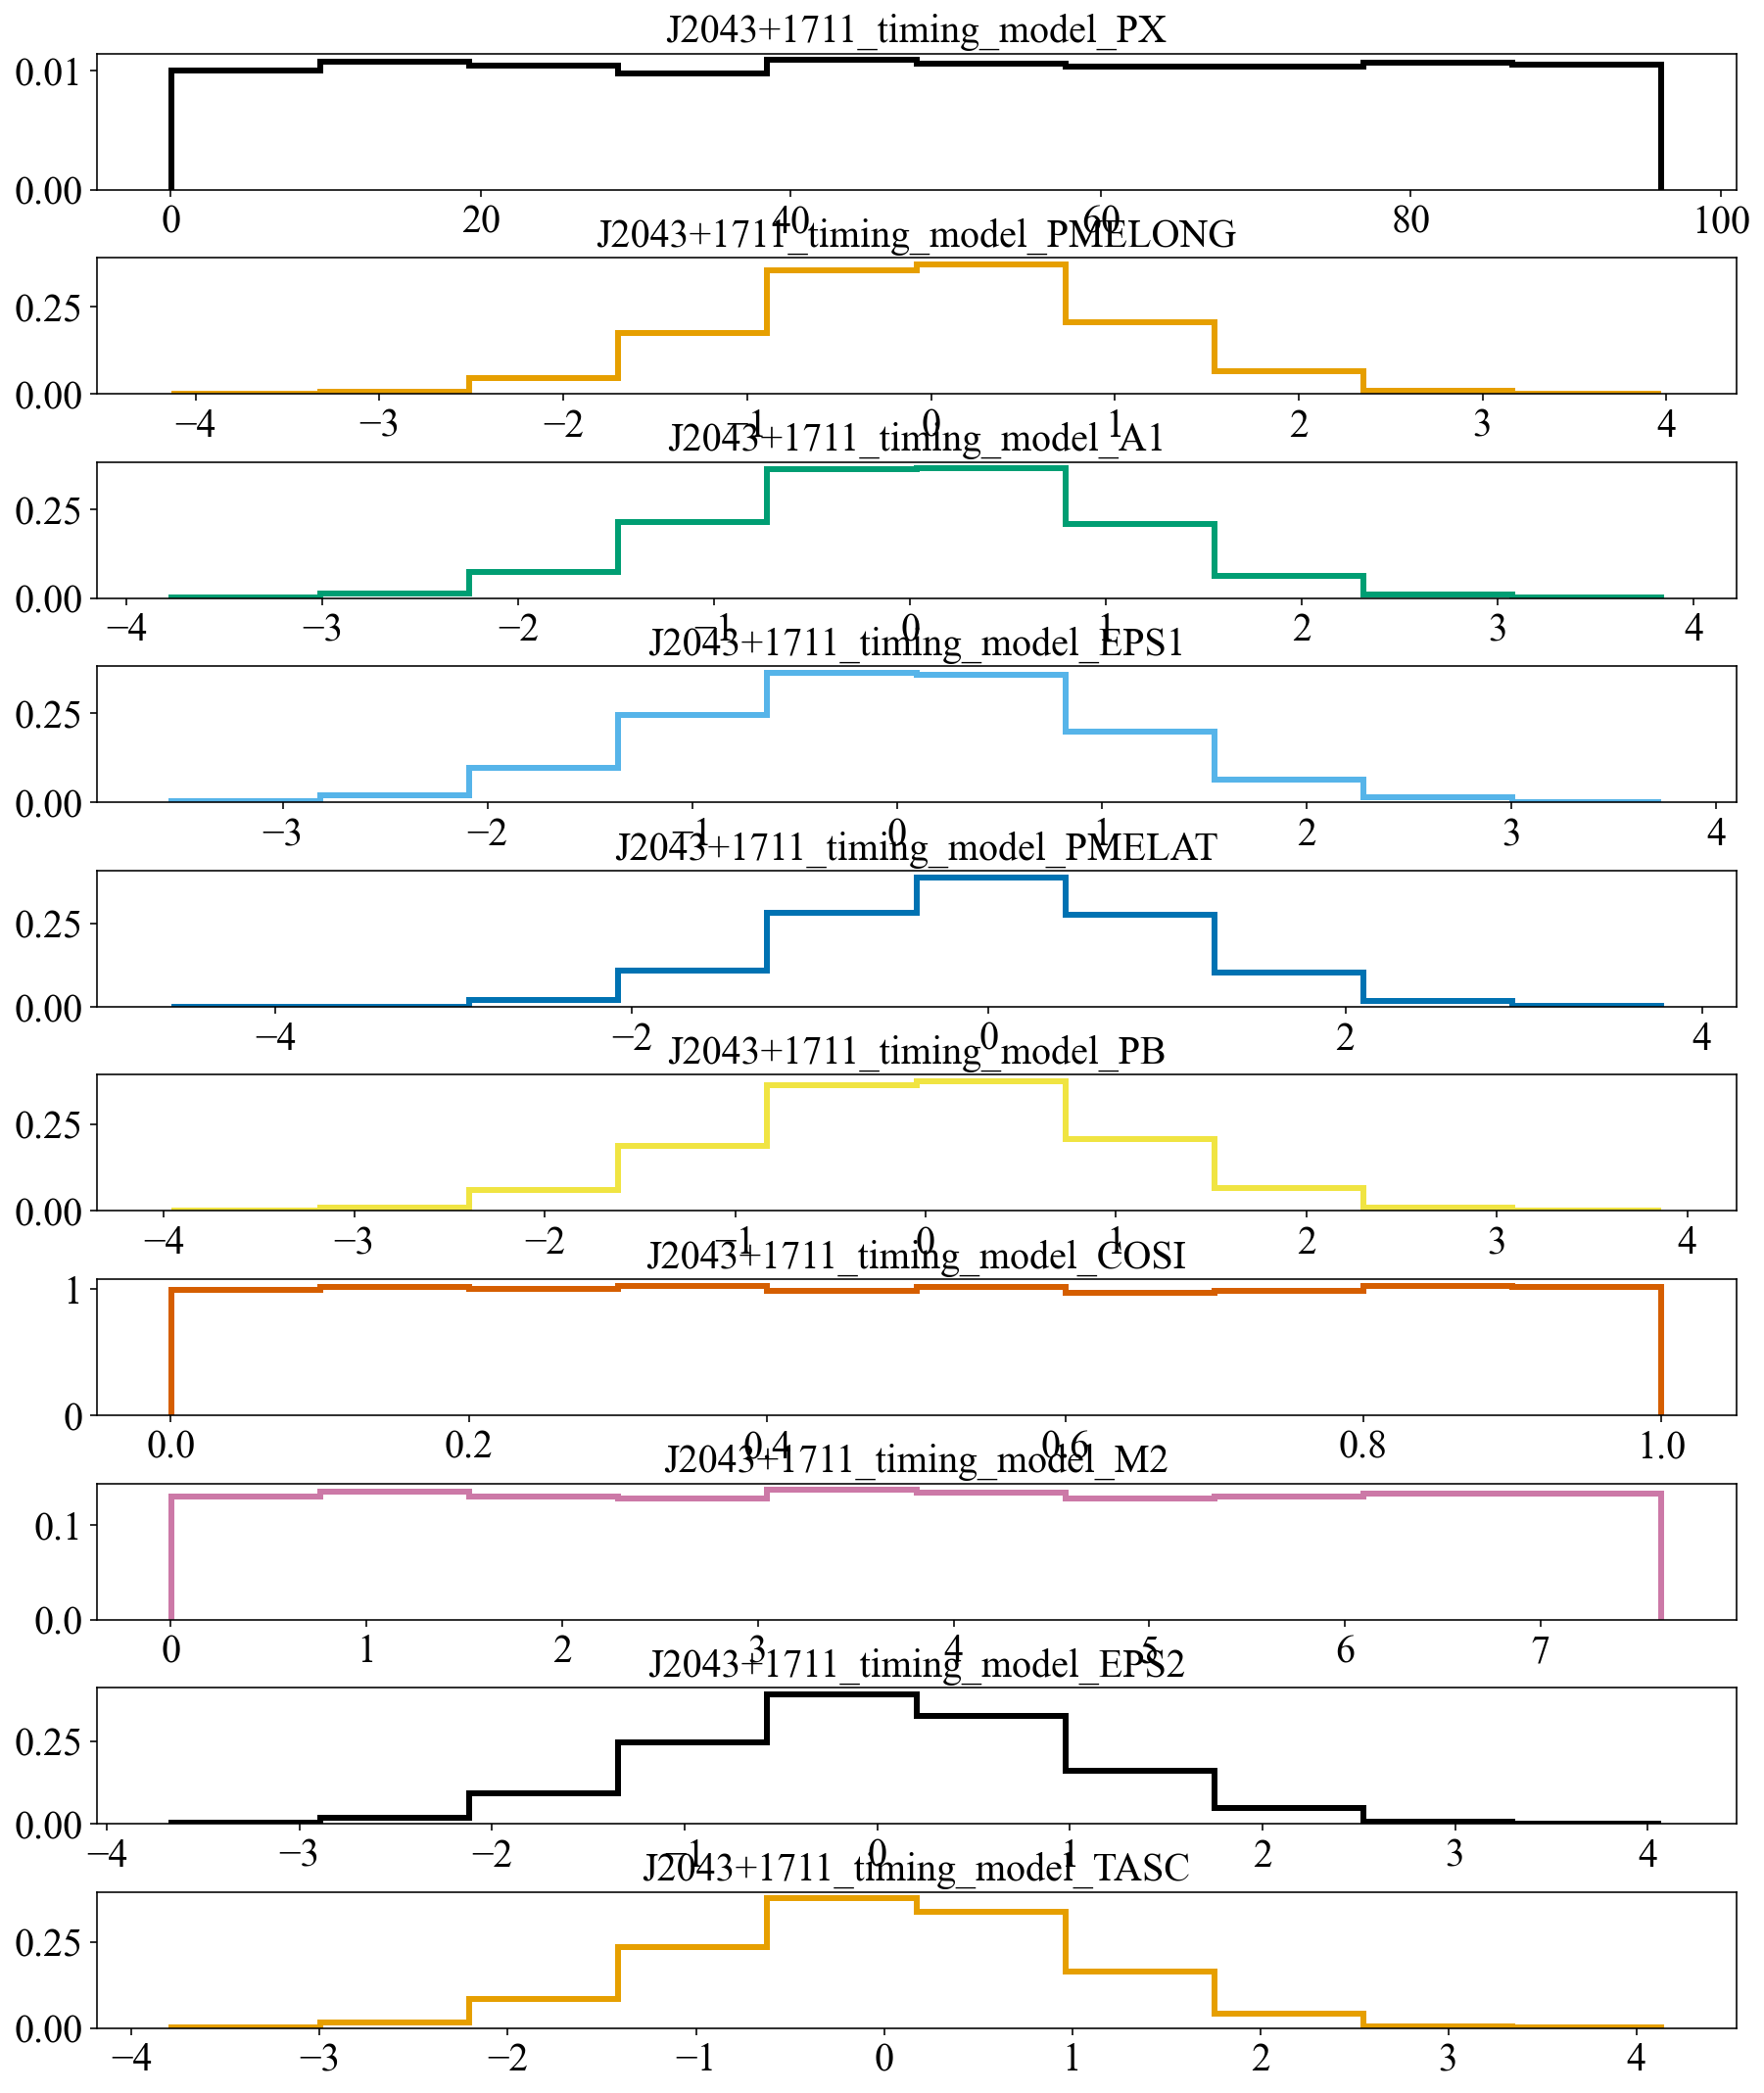

In [32]:
fig,ax = plt.subplots(len(tm_draws.keys()),1,figsize=get_fig_size(scale=.5))
for i,(key,vals) in enumerate(tm_draws.items()):
    ax[i].hist(vals,color=f'C{i}',histtype='step',linewidth=3.,density=True)
    ax[i].set_title(key)
fig.subplots_adjust(hspace=0.5)
plt.show()

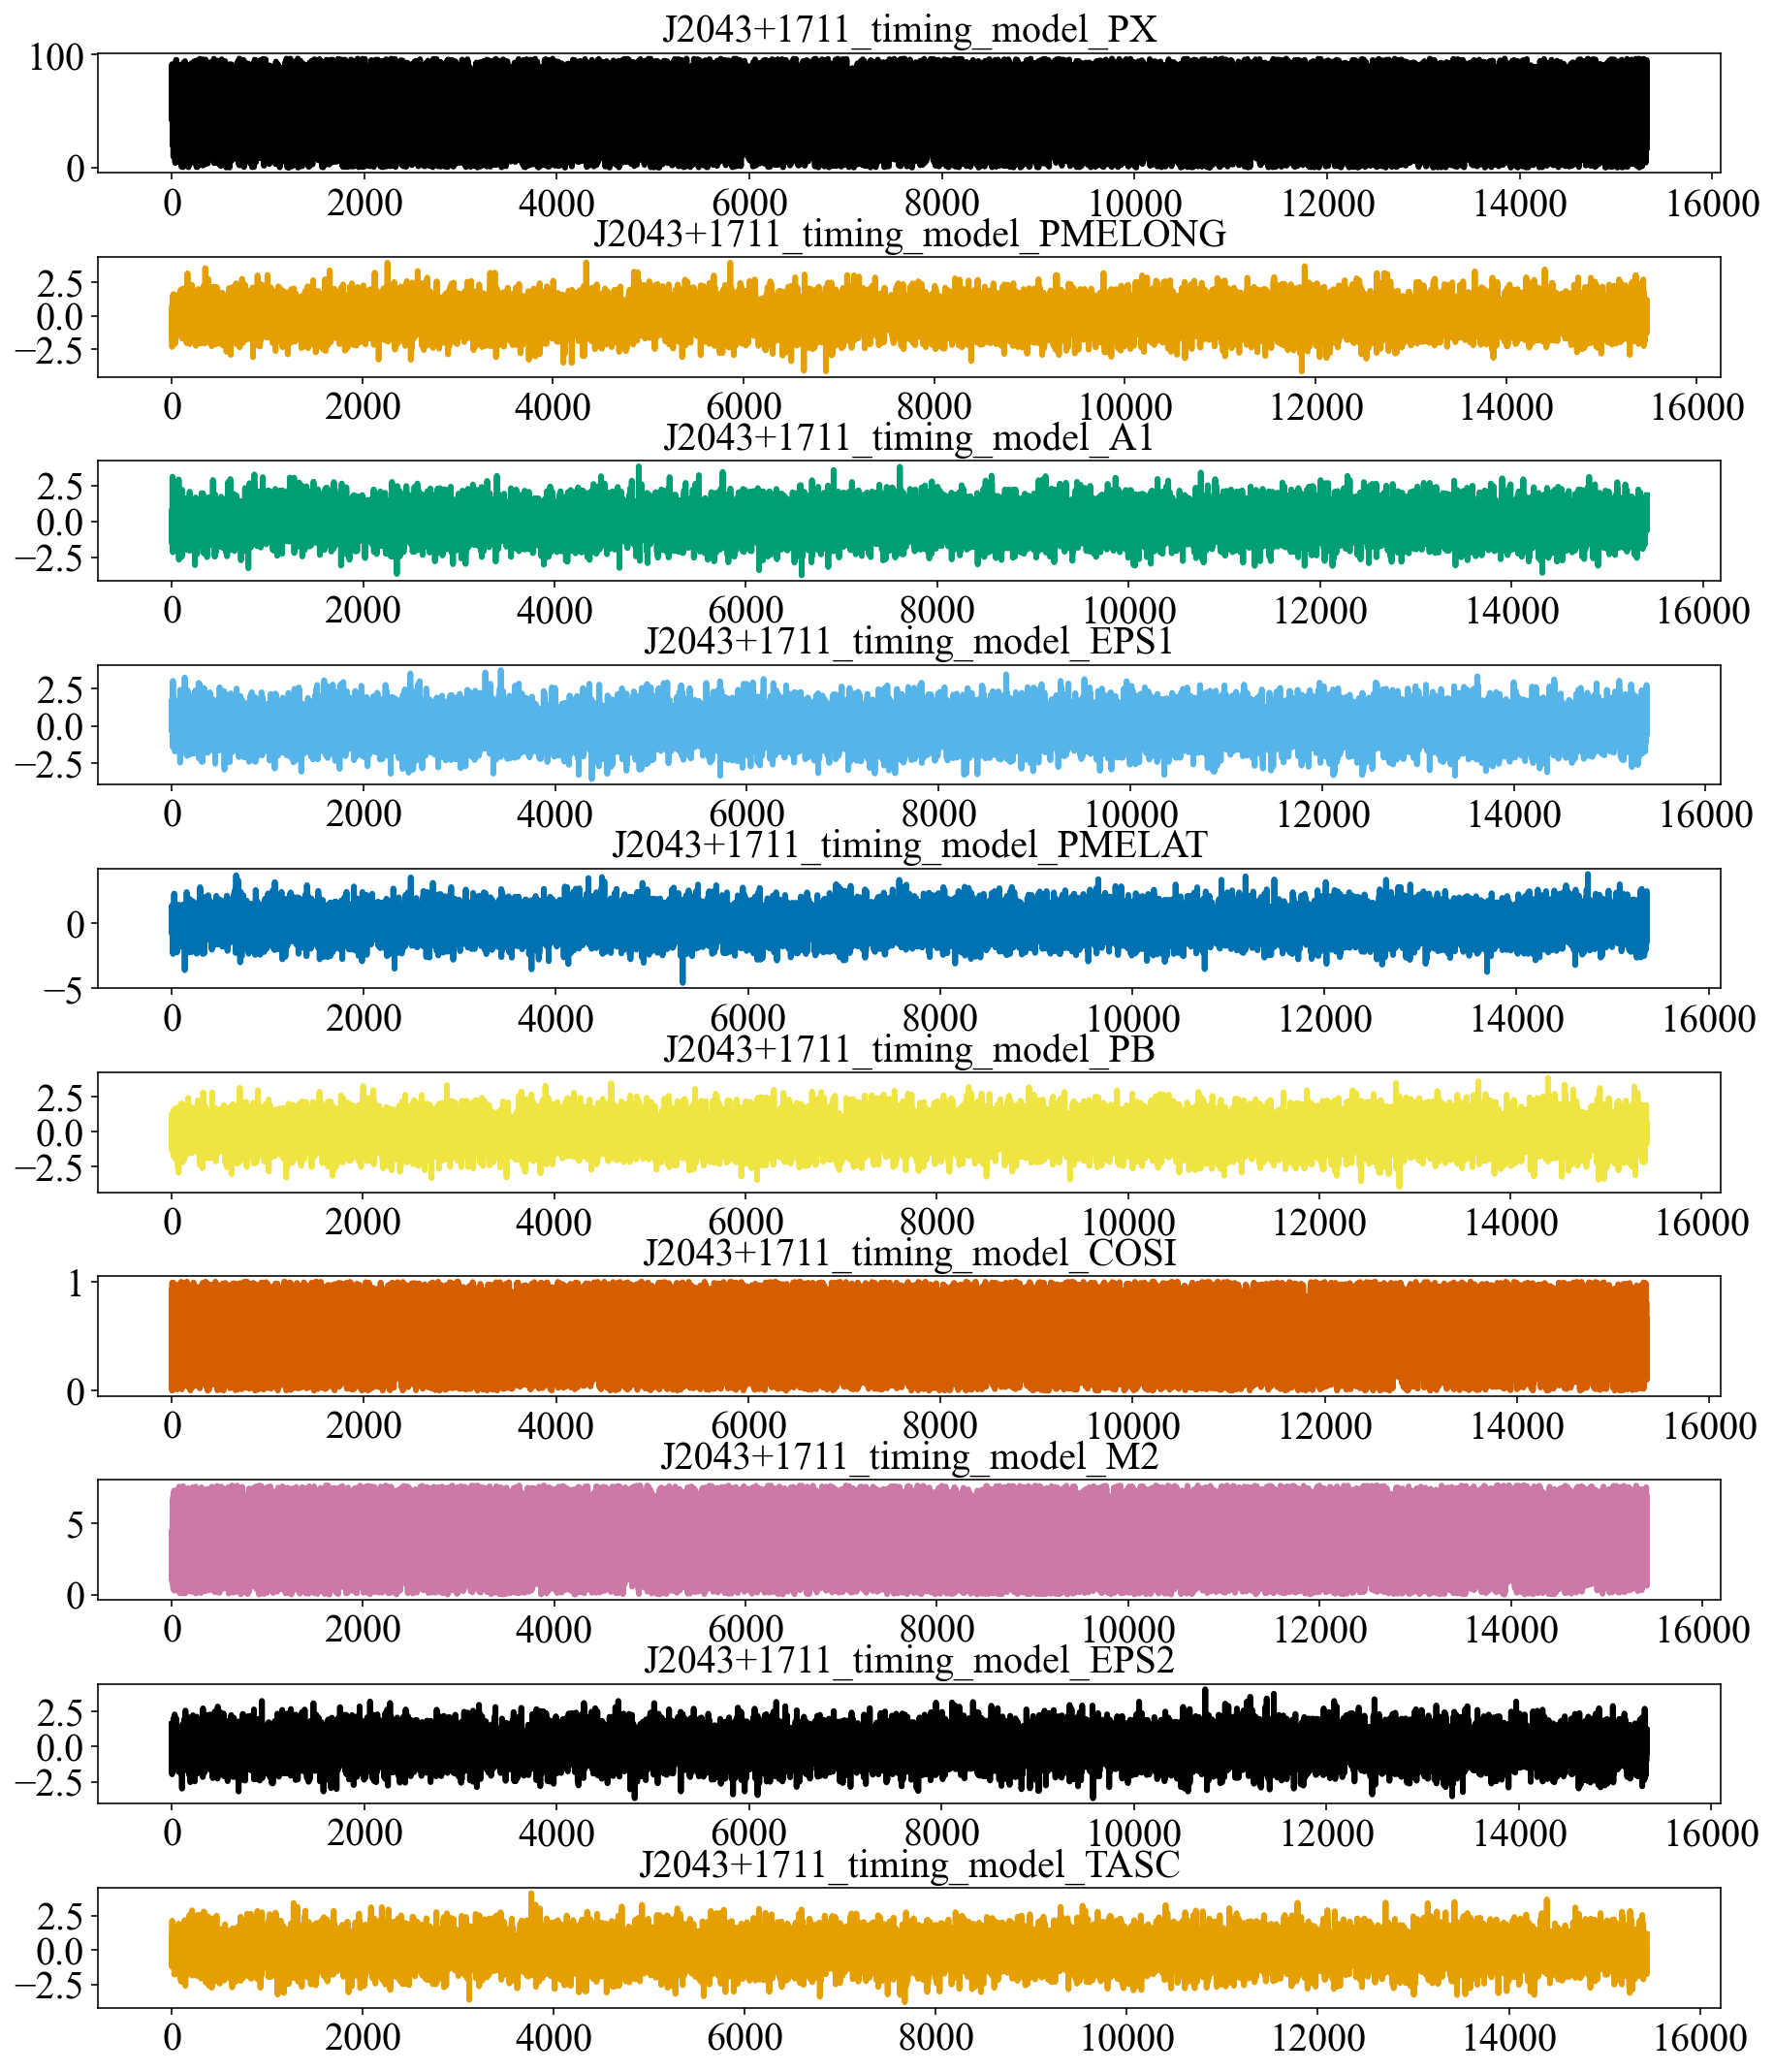

In [33]:
fig,ax = plt.subplots(len(tm_draws.keys()),1,figsize=get_fig_size(scale=.5))
for i,(key,vals) in enumerate(tm_draws.items()):
    ax[i].plot(range(len(vals)),vals,color=f'C{i}',linewidth=3.)
    ax[i].set_title(key)
fig.subplots_adjust(hspace=0.7)
plt.show()

In [34]:
print(np.min(tm_draws[f'{psr_name}_timing_model_COSI']))
print(np.max(tm_draws[f'{psr_name}_timing_model_COSI']))

0.0002323751893066328
0.999995490101057


# Prior Draws

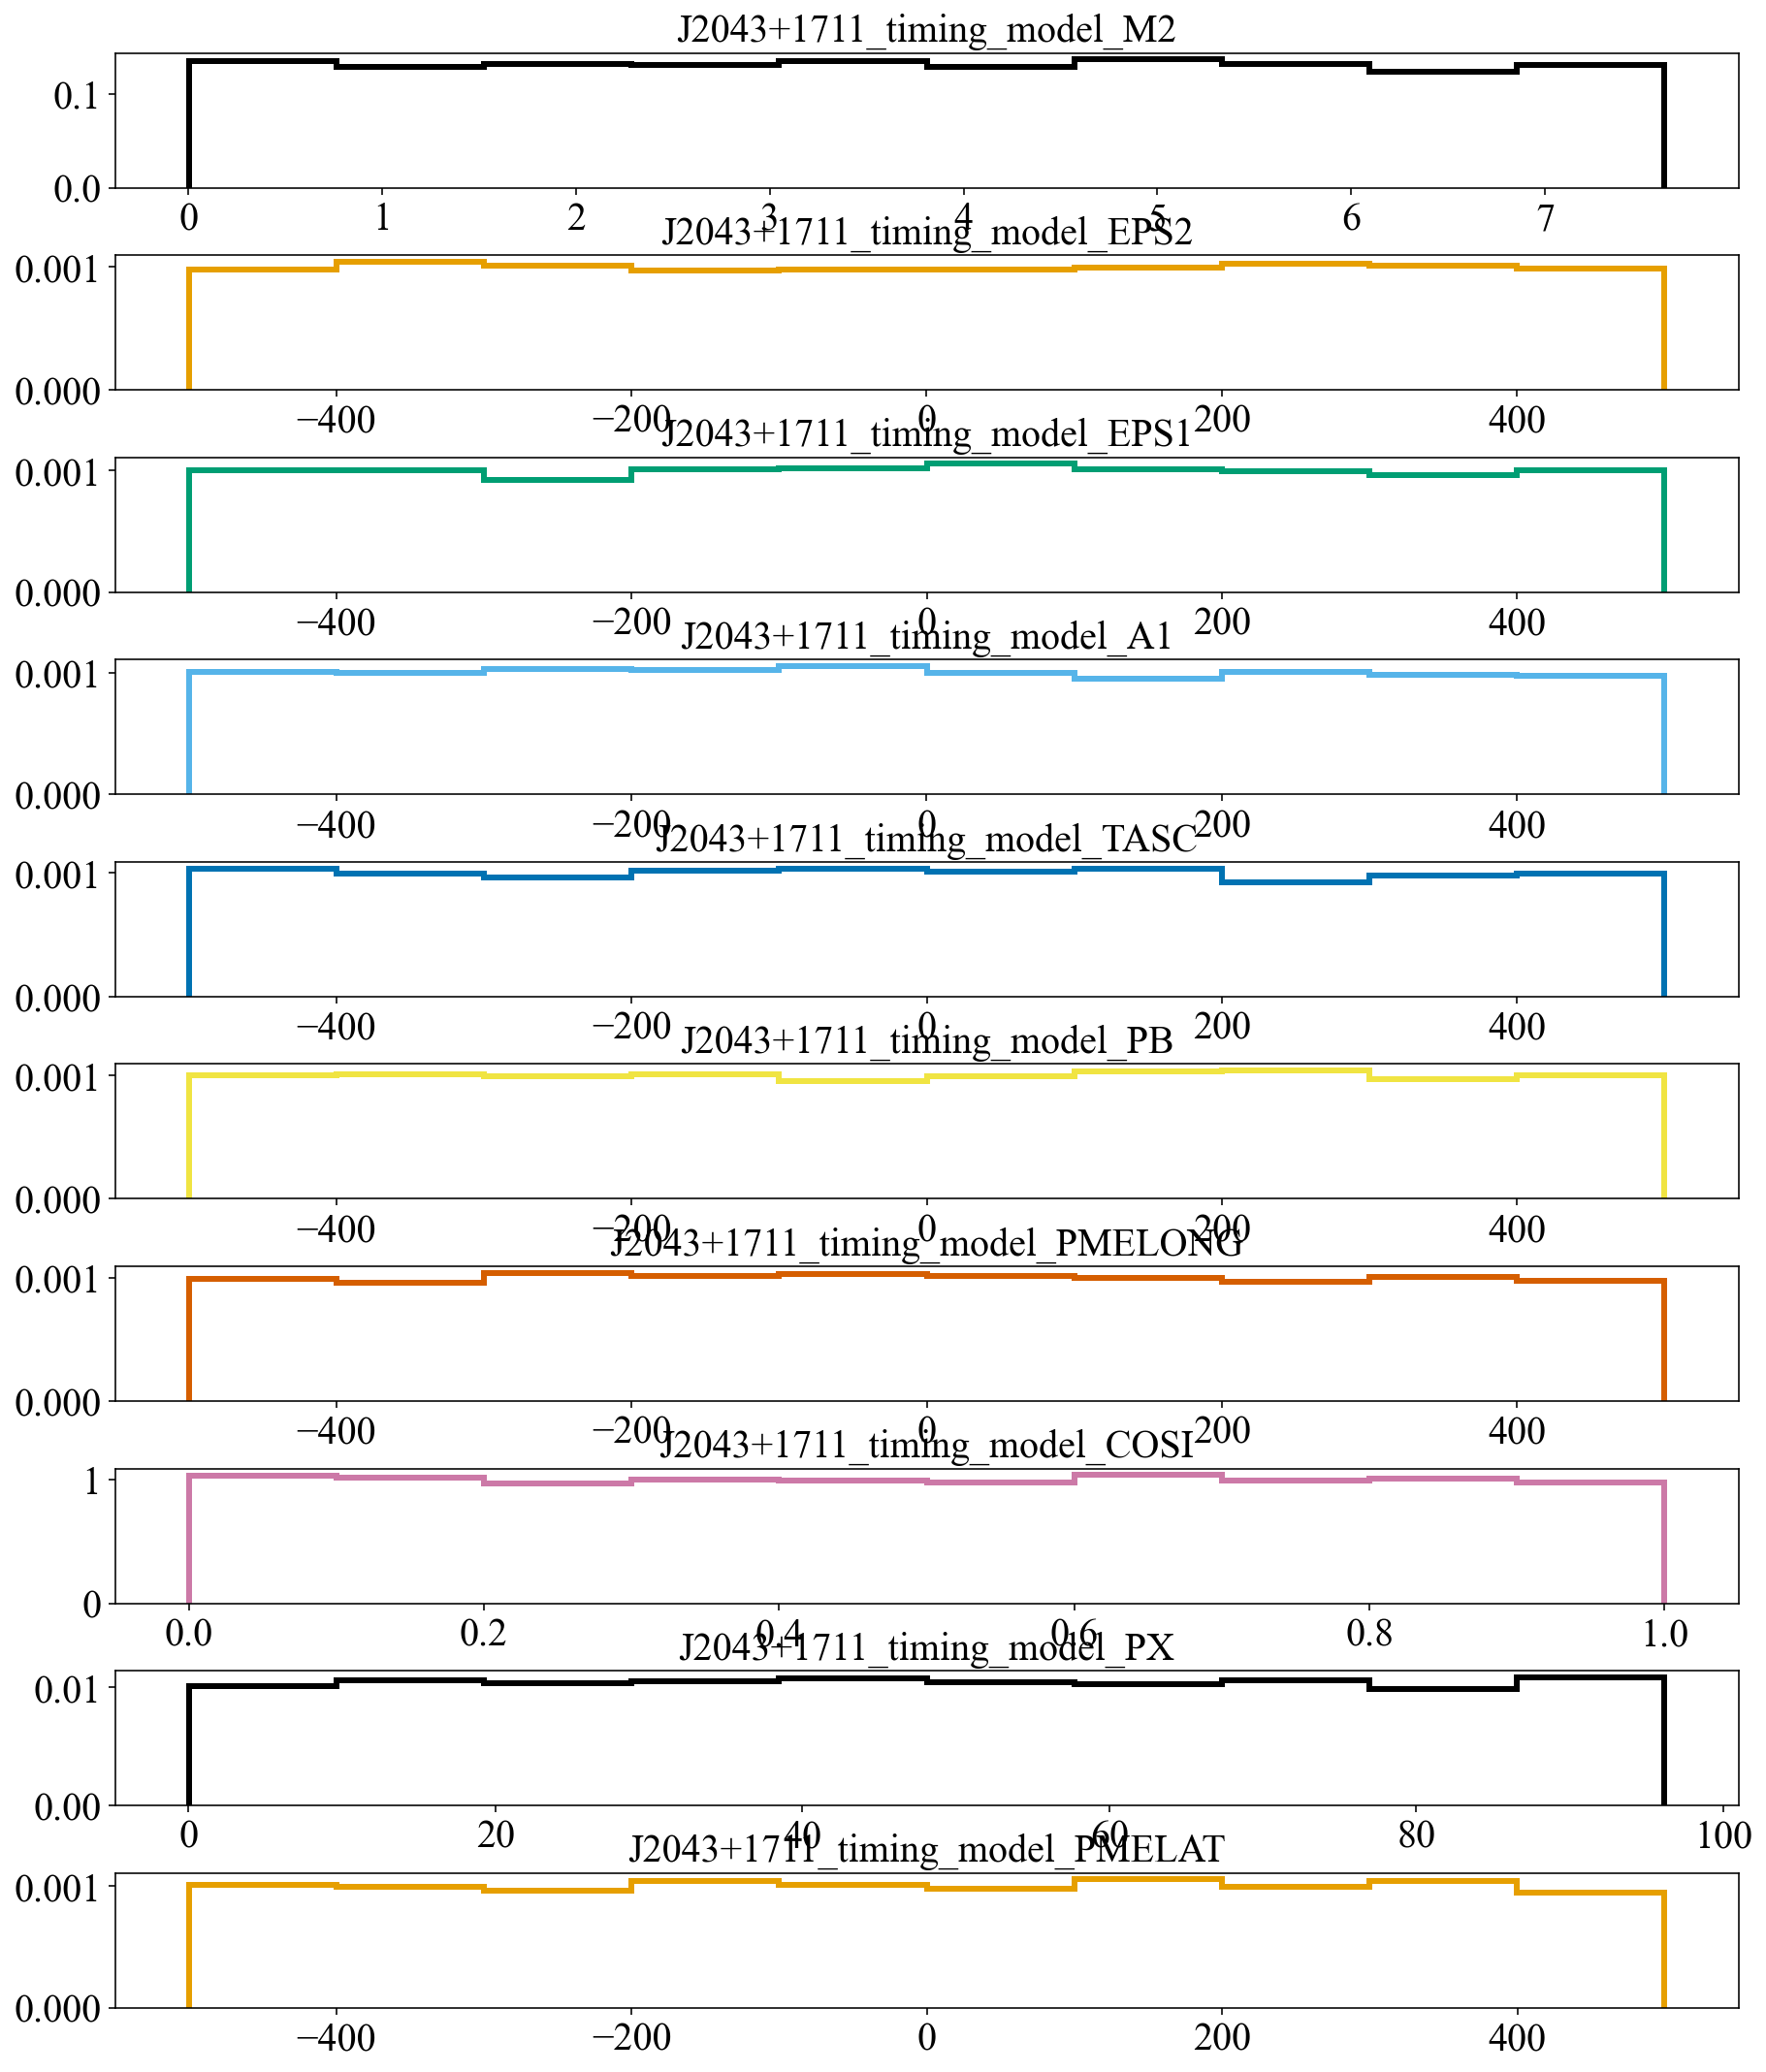

In [35]:
fig,ax = plt.subplots(len(tm_prior_draws.keys()),1,figsize=get_fig_size(scale=.5))
for i,(key,vals) in enumerate(tm_prior_draws.items()):
    ax[i].hist(vals,color=f'C{i}',histtype='step',linewidth=3.,density=True)
    ax[i].set_title(key)
fig.subplots_adjust(hspace=0.5)
plt.show()

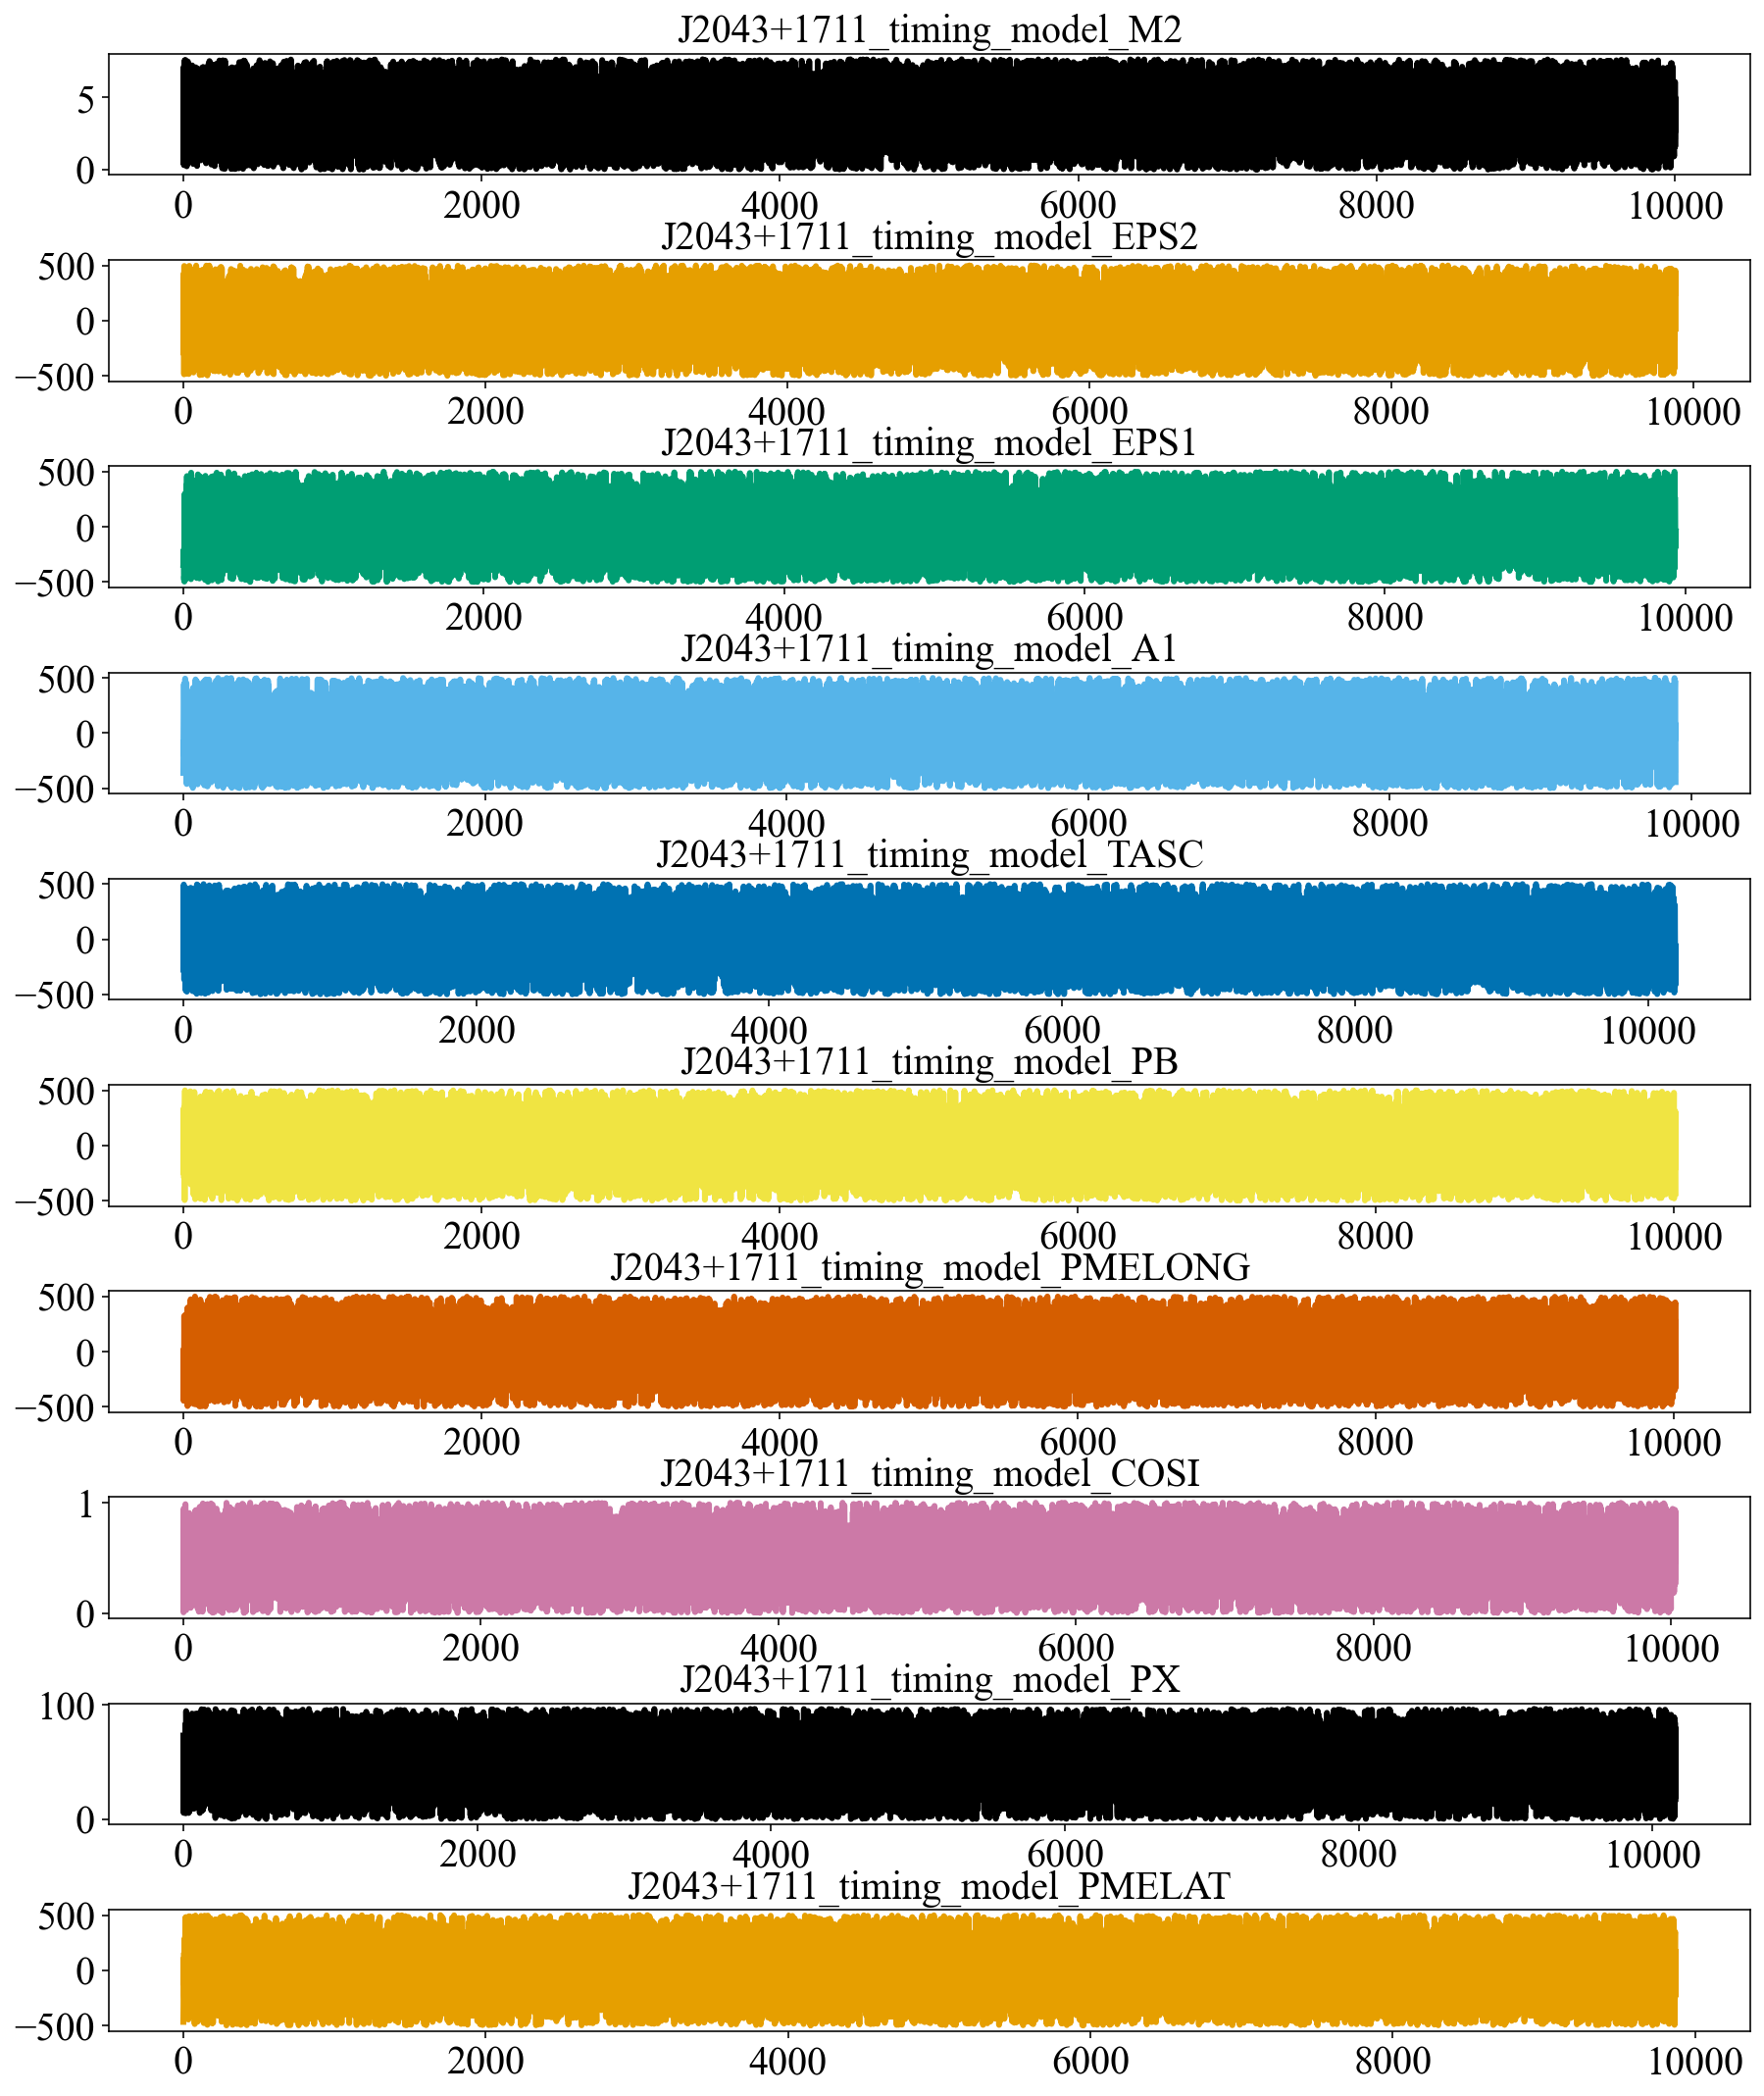

In [36]:
fig,ax = plt.subplots(len(tm_prior_draws.keys()),1,figsize=get_fig_size(scale=.5))
for i,(key,vals) in enumerate(tm_prior_draws.items()):
    ax[i].plot(range(len(vals)),vals,color=f'C{i}',linewidth=3.)
    ax[i].set_title(key)
fig.subplots_adjust(hspace=0.7)
plt.show()

In [37]:
print(np.min(tm_prior_draws[f'{psr_name}_timing_model_COSI']))
print(np.max(tm_prior_draws[f'{psr_name}_timing_model_COSI']))
print(np.min(tm_prior_draws[f'{psr_name}_timing_model_PX']))
print(np.max(tm_prior_draws[f'{psr_name}_timing_model_PX']))
print(np.min(tm_prior_draws[f'{psr_name}_timing_model_M2']))
print(np.max(tm_prior_draws[f'{psr_name}_timing_model_M2']))

3.19555829071394e-05
0.9999836134850997
0.035494085065561475
96.17650783104844
0.0019876208552545966
7.617617234667214
